In [1]:
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
# %matplotlib inline # plot in cell
from sklearn import metrics
import pandas as pd
from scipy import signal
from scipy import stats


import os
from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = 'all'

# for svm
from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix
from sklearn.svm import SVC

feature_names = ['mean_x', 'mean_y', 'mean_z', 
                'rms_x', 'rms_y', 'rms_z',
                'std_x', 'std_y', 'std_z',
                'var_x', 'var_y', 'var_z',
                'med_x', 'med_y', 'med_z',
                'min_x', 'min_y', 'min_z',
                'max_x', 'max_y', 'max_z', 
                 'pearsonr_xy', 'pearsonr_yz', 'pearsonr_zx']
#                 'mad_x', 'mad_y', 'mad_z']


target_names = ['Standing', 'Walking normal', 'Jumping', 
                'Jogging', 'Stairs up', 'Stairs down',
                'Fall front kness lying', 
                'Fall forward lying','Sideward lying']

def featuresFromBuffer(at):
    feat = np.zeros(24)
    x = np.array(at.iloc[:,0], dtype=np.float64) 
    y = np.array(at.iloc[:,1], dtype=np.float64)
    z = np.array(at.iloc[:,2], dtype=np.float64)
    
    means = [np.mean(i) for i in [x, y, z]]
    feat[0:3] = means
    
    rms = [np.sqrt(np.mean(i**2)) for i in [x, y, z]]
    feat[3:6] = rms
    
    std = [np.std(i) for i in [x, y, z]]
    feat[6:9] = std
  
    var = [np.var(i) for i in [x, y, z]]
    feat[9:12] = var
    
    med = [np.median(i) for i in [x, y, z]]
    feat[12:15] = med
       
    Range1 = [ np.amin(i) for i in [x, y, z]]   
    feat[15:18] = Range1
    Range2 = [ np.amax(i) for i in [x, y, z]]    
    feat[18:21] = Range2
    
    x_pd = pd.Series(x)
    y_pd = pd.Series(y)
    z_pd = pd.Series(z)
    Pearsonr_xy = x_pd.corr(y_pd)
    feat[21] = Pearsonr_xy
    Pearsonr_yz = y_pd.corr(z_pd)
    feat[22] = Pearsonr_yz
    Pearsonr_zx = z_pd.corr(x_pd)
    feat[23] = Pearsonr_zx
    
#     mad = [stats.median_absolute_deviation(i) for i in [x, y, z]]   
#     feat[24:27] = mad
    
    return feat

In [2]:
# Import data

dt = pd.read_excel (r'F:\Program\OneDrive\KHOÁ LUẬN 2020\Exactly_Data.xlsx')
dt.columns
dt.shape

Index(['STD', 'Unnamed: 1', 'Unnamed: 2', 'WAL', 'Unnamed: 4', 'Unnamed: 5',
       'JUM', 'Unnamed: 7', 'Unnamed: 8', 'JOG', 'Unnamed: 10', 'Unnamed: 11',
       'STU', 'Unnamed: 13', 'Unnamed: 14', 'STN', 'Unnamed: 16',
       'Unnamed: 17', 'FKL', 'Unnamed: 19', 'Unnamed: 20', 'FOL',
       'Unnamed: 22', 'Unnamed: 23', 'SDL', 'Unnamed: 25', 'Unnamed: 26'],
      dtype='object')

(28939, 27)

In [3]:
Standing = dt[['STD', 'Unnamed: 1', 'Unnamed: 2']] 
Standing = Standing.dropna()
Standing.index = pd.RangeIndex(len(Standing.index))
Standing = Standing.drop(0)

Walking_normal = dt[['WAL', 'Unnamed: 4', 'Unnamed: 5']] 
Walking_normal = Walking_normal.dropna()
Walking_normal.index = pd.RangeIndex(len(Walking_normal.index))
Walking_normal = Walking_normal.drop(0)

Jumping = dt[['JUM', 'Unnamed: 7', 'Unnamed: 8']] 
Jumping = Jumping.dropna()
Jumping.index = pd.RangeIndex(len(Jumping.index))
Jumping = Jumping.drop(0)

Jogging = dt[['JOG', 'Unnamed: 10', 'Unnamed: 11']] 
Jogging = Jogging.dropna()
Jogging.index = pd.RangeIndex(len(Jogging.index))
Jogging = Jogging.drop(0)

Stairs_up = dt[['STU', 'Unnamed: 13', 'Unnamed: 14']] 
Stairs_up = Stairs_up.dropna()
Stairs_up.index = pd.RangeIndex(len(Stairs_up.index)) 
Stairs_up = Stairs_up.drop(0)
    
Stairs_down = dt[['STN', 'Unnamed: 16', 'Unnamed: 17']] 
Stairs_down = Stairs_down.dropna()
Stairs_down.index = pd.RangeIndex(len(Stairs_down.index))
Stairs_down = Stairs_down.drop(0)
    

Fall_front_knees_lying = dt[['FKL', 'Unnamed: 19', 'Unnamed: 20']]
Fall_front_knees_lying = Fall_front_knees_lying.dropna()
Fall_front_knees_lying.index = pd.RangeIndex(len(Fall_front_knees_lying.index)) 
Fall_front_knees_lying = Fall_front_knees_lying.drop(0)

Fall_forward_lying = dt[['FOL', 'Unnamed: 22', 'Unnamed: 23']] 
Fall_forward_lying = Fall_forward_lying.dropna()
Fall_forward_lying.index = pd.RangeIndex(len(Fall_forward_lying.index)) 
Fall_forward_lying = Fall_forward_lying.drop(0)

Sideward_lying = dt[['SDL', 'Unnamed: 25', 'Unnamed: 26']] 
Sideward_lying = Sideward_lying.dropna()
Sideward_lying.index = pd.RangeIndex(len(Sideward_lying.index)) 
Sideward_lying = Sideward_lying.drop(0)



In [4]:
type(Standing)
type(Jumping)
type(Stairs_up)
type(Fall_forward_lying)

pandas.core.frame.DataFrame

pandas.core.frame.DataFrame

pandas.core.frame.DataFrame

pandas.core.frame.DataFrame

In [5]:
# Convert pandas datatype to list

Standing = Standing.values.tolist()
Walking_normal = Walking_normal.values.tolist()
Jumping = Jumping.values.tolist()
Jogging = Jogging.values.tolist()
Stairs_up = Stairs_up.values.tolist()
Stairs_down = Stairs_down.values.tolist()
Fall_front_knees_lying = Fall_front_knees_lying.values.tolist()
Fall_forward_lying = Fall_forward_lying.values.tolist()
Sideward_lying = Sideward_lying.values.tolist()


In [6]:

Standing[1]
s = 0
for i in Standing[1]:
    s += i*i
s = np.sqrt(s)
print(s)



[1.1587936, 9.720459, 1.0821792]

9.848920631165356


In [7]:
sstd = 0
STD = []
for stdi in Standing:
    for stdj in stdi: 
        sstd += stdj*stdj
    sstd = np.sqrt(sstd)
    STD.append(sstd)


swal = 0
WAL = []
for wali in Walking_normal:
    for walj in wali: 
        swal += walj*walj
    swal = np.sqrt(swal)
    WAL.append(swal)


sjum = 0
JUM = []
for jumi in Jumping:
    for jumj in jumi: 
        sjum += jumj*jumj
    sjum = np.sqrt(sjum)
    JUM.append(sjum)

    
sjog = 0
JOG = []
for jogi in Jogging:
    for jogj in jogi: 
        sjog += jogj*jogj
    sjog = np.sqrt(sjog)
    JOG.append(sjog)


sstu = 0
STU = []
for stui in Stairs_up:
    for stuj in stui: 
        sstu += stuj*stuj
    sstu = np.sqrt(sstu)
    STU.append(sstu)
    
sstn = 0
STN = []
for stni in Stairs_down:
    for stnj in stni: 
        sstn += stnj*stnj
    sstn = np.sqrt(sstn)
    STN.append(sstn)

    
sfkl = 0
FKL = []
for fkli in Fall_front_knees_lying:
    for fklj in fkli: 
        sfkl += fklj*fklj
    sfkl = np.sqrt(sfkl)
    FKL.append(sfkl)
    

sfol = 0
FOL = []
for foli in Fall_forward_lying:
    for folj in foli: 
        sfol += folj*folj
    sfol = np.sqrt(sfol)
    FOL.append(sfol)
    
    
    
ssdl = 0
SDL = []
for sdli in Sideward_lying:
    for sdlj in sdli: 
        ssdl += sdlj*sdlj
    ssdl = np.sqrt(ssdl)
    SDL.append(ssdl)
    


In [8]:
# Split dataset to 2 parts: Train (60%) - Test (40%)\n",

window_size = 16
stride = 6 #step

# range (start, stop, step)
X_stand_train = [STD[i:i+window_size] for i in range(0, int(len(STD)*0.6), stride)] 
X_stand_test = [STD[i:i+window_size] for i in range(int(len(STD)*0.6), len(STD), stride) 
                                            if i+window_size<=len(STD)]

X_walk_train = [WAL[i:i+window_size] for i in range(0, int(len(WAL)*0.6), stride)]
X_walk_test = [WAL[i:i+window_size] for i in range(int(len(WAL)*0.6), len(WAL),stride) 
                                            if i+window_size<=len(WAL)]

X_jump_train = [JUM[i:i+window_size] for i in range(0, int(len(JUM)*0.6), stride)]
X_jump_test = [JUM[i:i+window_size] for i in range(int(len(JUM)*0.6), len(JUM), stride) 
                                            if i+window_size<=len(JUM)]

X_jog_train = [JOG[i:i+window_size] for i in range(0, int(len(JOG)*0.6), stride)] 
X_jog_test = [JOG[i:i+window_size] for i in range(int(len(JOG)*0.6), len(JOG), stride) 
                                        if i+window_size<=len(JOG)]
                                       
X_stairUp_train = [STU[i:i+window_size] for i in range(0, int(len(STU)*0.6), stride)] 
X_stairUp_test = [STU[i:i+window_size] for i in range(int(len(STU)*0.6), len(STU), stride) 
                                                if i+window_size<=len(STU)]

X_stairDown_train = [STN[i:i+window_size] for i in range(0, int(len(STN)*0.6), stride)] 
X_stairDown_test = [STN[i:i+window_size] for i in range(int(len(STN)*0.6), len(STN), 
                                                                stride) if i+window_size<=len(STN)]

X_fallKnee_train = [FKL[i:i+window_size] for i in range(0, int(len(FKL)*0.6), stride)]
X_fallKnee_test = [FKL[i:i+window_size] for i in range(int(len(FKL)*0.6),len(FKL), stride) if i+window_size<=len(FKL)]

X_fallForward_train = [FOL[i:i+window_size] for i in range(0, int(len(FOL)*0.6), stride)]
X_fallForward_test = [FOL[i:i+window_size] for i in range(int(len(FOL)*0.6), 
                    len(FOL), stride) if i+window_size<=len(FOL)]

X_sideward_train = [SDL[i:i+window_size] for i in range(0, int(len(SDL)*0.6), stride)] 
X_sideward_test = [SDL[i:i+window_size] for i in range(int(len(SDL)*0.6), 
                    len(SDL), stride) if i+window_size<=len(SDL)]


print ('X_stand_train: ', len(X_stand_train))
print ('X_stand_test: ', len(X_stand_test))

print ('X_walk_train: ', len(X_walk_train))
print ('X_walk_test: ', len(X_walk_test))

print ('X_jump_train: ', len (X_jump_train))
print ('X_jump_test: ', len (X_jump_test))

print ('X_jog_train: ', len (X_jog_train))
print ('X_jog_test: ', len (X_jog_test))

print ('X_stairUp_train: ', len (X_stairUp_train))
print ('X_stairUp_test: ', len (X_stairUp_test))

print ('X_stairDown_train: ', len (X_stairDown_train))
print ('X_stairDown_test: ', len (X_stairDown_test))

print ('X_fallKnee_train: ', len (X_fallKnee_train))
print ('X_fallKnee_test: ', len (X_fallKnee_test))

print ('X_fallForward_train: ', len (X_fallForward_train))
print ('X_fallForward_test: ', len (X_fallForward_test))

print ('X_sideward_train: ', len (X_sideward_train))
print ('X_sideward_test: ', len (X_sideward_test))

type(X_stand_train)

X_stand_train:  2894
X_stand_test:  1927
X_walk_train:  2616
X_walk_test:  1742
X_jump_train:  791
X_jump_test:  525
X_jog_train:  791
X_jog_test:  525
X_stairUp_train:  485
X_stairUp_test:  321
X_stairDown_train:  475
X_stairDown_test:  314
X_fallKnee_train:  260
X_fallKnee_test:  171
X_fallForward_train:  241
X_fallForward_test:  158
X_sideward_train:  259
X_sideward_test:  170


list

In [9]:
train_data = []
train_label = []

test_data = []
test_label = []

for acts in X_stand_train:
    train_data.append(acts)
    train_label.append(0)
    
train_data
type(train_data)  
for acts in X_walk_train:
    train_data.append(acts)
    train_label.append(1)

for acts in X_jump_train:
    train_data.append(acts)
    train_label.append(2)

for acts in X_jog_train:
    train_data.append(acts)
    train_label.append(3)

for acts in X_stairUp_train:
    train_data.append(acts)
    train_label.append(4)

for acts in X_stairDown_train:
    train_data.append(acts)
    train_label.append(5)

for acts in X_fallKnee_train:
    train_data.append(acts)
    train_label.append(6)

for acts in X_fallForward_train:
    train_data.append(acts)
    train_label.append(7)

for acts in X_sideward_train:
    train_data.append(acts)
    train_label.append(8)

print('train-data length: ', len(train_data) )
print('train-label length: ', len(train_label) )
      
# For TEST

for acts in X_stand_test:
    test_data.append(acts)
    test_label.append(0)

for acts in X_walk_test:
    test_data.append(acts)
    test_label.append(1)

for acts in X_jump_test:
    test_data.append(acts)
    test_label.append(2)

for acts in X_jog_test:
    test_data.append(acts)
    test_label.append(3)

for acts in X_stairUp_test:
    test_data.append(acts)
    test_label.append(4)

for acts in X_stairDown_test:
    test_data.append(acts)
    test_label.append(5)

for acts in X_fallKnee_test:
    test_data.append(acts)
    test_label.append(6)

for acts in X_fallForward_test:
    test_data.append(acts)
    test_label.append(7)

for acts in X_sideward_test:
    test_data.append(acts)
    test_label.append(8)

print('test-data length: ', len(test_data))
print('test-label length: ', len(test_label))



[[9.94674396241928,
  10.341565720983157,
  10.3125907554646,
  10.283057542364302,
  10.339582925382706,
  10.429250997480102,
  10.423893222867132,
  10.306548913361887,
  10.287182904901597,
  10.308285825898368,
  10.33502736955074,
  10.434936623457554,
  10.45571755298291,
  10.450797977084493,
  10.410360776994638,
  10.445835316559764],
 [10.423893222867132,
  10.306548913361887,
  10.287182904901597,
  10.308285825898368,
  10.33502736955074,
  10.434936623457554,
  10.45571755298291,
  10.450797977084493,
  10.410360776994638,
  10.445835316559764,
  10.491461930743796,
  10.550810949430984,
  10.562548715640478,
  10.524971186667798,
  10.471440906884494,
  10.4671797345569],
 [10.45571755298291,
  10.450797977084493,
  10.410360776994638,
  10.445835316559764,
  10.491461930743796,
  10.550810949430984,
  10.562548715640478,
  10.524971186667798,
  10.471440906884494,
  10.4671797345569,
  10.396884502526555,
  10.382970471756295,
  10.354307555849502,
  10.331871561959613,

list

train-data length:  8812
train-label length:  8812
test-data length:  5853
test-label length:  5853



train_features = []
test_features = []
for action in train_data:
    feat = featuresFromBuffer(action)
    train_features.append(feat)  

for action in test_data:
    feat = featuresFromBuffer(action)
    test_features.append(feat)

len(train_features)
len(test_features)


In [20]:
#train_features = np.asarray(train_features)
#type(train_features): numpy.ndarray
#train_features.shape: (8812,24) - 2D

train_data = np.asarray(train_data)
type(train_data)
train_data.shape # (8812, 16, 3) - 3D

train_data


numpy.ndarray

(8812, 16)

array([[ 9.94674396, 10.34156572, 10.31259076, ..., 10.45079798,
        10.41036078, 10.44583532],
       [10.42389322, 10.30654891, 10.2871829 , ..., 10.52497119,
        10.47144091, 10.46717973],
       [10.45571755, 10.45079798, 10.41036078, ..., 10.33187156,
        10.31002567, 10.27908371],
       ...,
       [10.18909893, 10.24167265, 10.2454879 , ..., 10.20623712,
        10.21219442, 10.18212194],
       [10.18423732, 10.17140276, 10.1763882 , ..., 10.1881278 ,
        10.18877452, 10.18177805],
       [10.25253174, 10.20623712, 10.21219442, ..., 10.22542699,
        10.22835722, 10.19928126]])

9


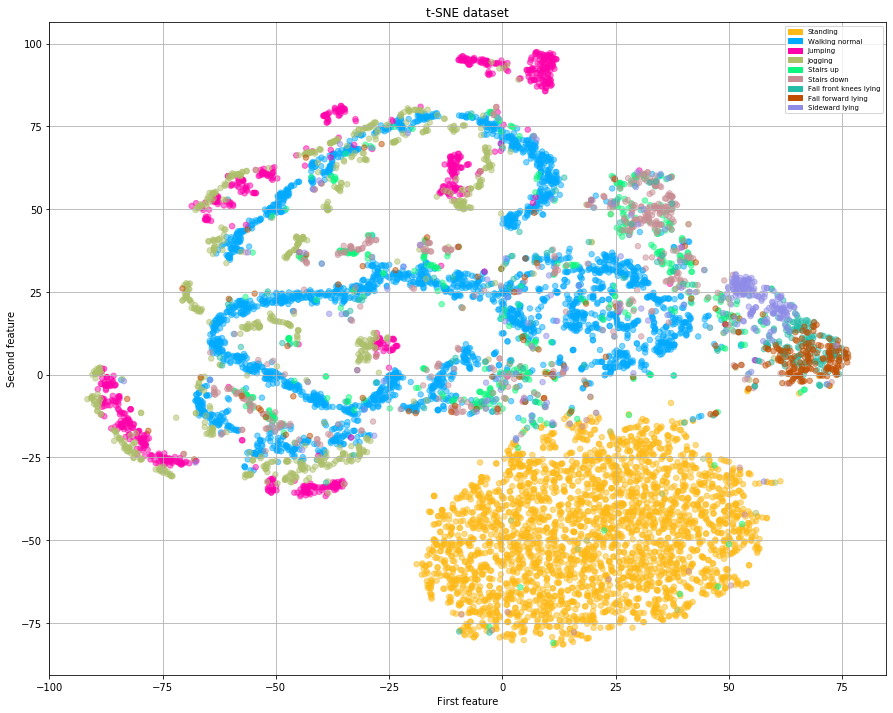

In [21]:
# t-SNE

import numpy
import pandas as pd
import seaborn as sn
import matplotlib.pyplot as plt
import matplotlib.cm as cm
from matplotlib.colors import ListedColormap, BoundaryNorm
from sklearn import neighbors
import graphviz 
from sklearn.tree import export_graphviz
import matplotlib.patches as mpatches


def plot_labelled_scatter(X, y, class_labels):
    num_labels = len(class_labels)
    print(num_labels)

    # create a mesh (lưới) to plot the boundaries (đường biên)
    x_min, x_max = X[:, 0].min() - 1, X[:, 0].max() + 1   # min & max for feature 1 ((column 0)) 
                    # X[row, column]
    y_min, y_max = X[:, 1].min() - 1, X[:, 1].max() + 1   # min & max for feature 2 (column 1)
    

    # marker_shapes = ['v', 's', 'o', '^', '*']
    # Create array color of 7 behaviors
    colors = ['#fdb915', '#00AAFF', '#FF00AA', '#acbf69', 
              '#0bf77d','#c88d94',
              '#24bca8', '#c04e01','#8f8ce7']
    cmap = ListedColormap(colors) 
    
   # Generate a colormap index based on discrete intervals
    norm = BoundaryNorm(numpy.arange(0, num_labels+1, 1), ncolors=num_labels) 
    
    plt.figure(figsize=(15, 12))  # độ dài row & column của 
    
    plt.scatter(X[:, 0], X[:, 1], s=30, c=y, cmap=cmap, norm=norm, alpha=0.5, lw=1)
                #edgecolor='black'
    
    # Create array h[] chứa chú thích behaviors & colors tương ứng
    h = []
    for c in range(0, num_labels):
        # tạo chú thích = mpatches.Patch
        h.append(mpatches.Patch(color=colors[c], label=class_labels[c])) 
    plt.legend(handles=h, fontsize = 'x-small') # show ghi chu
    
    plt.xlabel('First feature')
    plt.ylabel('Second feature')
    plt.title('t-SNE dataset')
    plt.grid(b=True)
    plt.show()
    
X_visual = train_data
y_visual = np.array(train_label, dtype=np.uint8) # np.array: create array
                                                    # np.uint8: unsigned integer
from sklearn.manifold import TSNE

# fit X_visual into embedding space in low-dimensional space and return  array (n_samples, n_components) 
X_tsne = TSNE(random_state=1000,n_components=2, perplexity=30.0, learning_rate=300.0).fit_transform(X_visual)
plot_labelled_scatter(X_tsne, y_visual,['Standing','Walking normal','Jumping','Jogging',
                                        'Stairs up','Stairs down','Fall front knees lying',
                                        'Fall forward lying','Sideward lying'])